In [2]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots as tsaplots
from sklearn.model_selection import train_test_split
from copy import deepcopy #helper to copy list objects...
from sklearn.metrics import mean_squared_error

from pmdarima import auto_arima # This library is to find automatically the best PDQ parameters 

import warnings #simplify alerts

warnings.simplefilter(action='ignore')

<h1> Weather Data </h1>
<p> This API pulls Weather Data by day </p>

In [76]:
import urllib.request
import sys
import json
                
try: 
  ResultBytes = urllib.request.urlopen("https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/4401%204th%20Ave%20S%2C%20Seattle%2C%20WA%2098134/2021-03-01/2023-11-05?unitGroup=us&include=days&key=KEY HIDDEN FOR GITHUB ENTER YOUR KEY&contentType=json")

  # Parse the results as JSON
  jsonData = json.load(ResultBytes)
          
except urllib.error.HTTPError  as e:
  ErrorInfo= e.read().decode() 
  print('Error code: ', e.code, ErrorInfo)
  sys.exit()
except  urllib.error.URLError as e:
  ErrorInfo= e.read().decode() 
  print('Error code: ', e.code,ErrorInfo)
  sys.exit()



In [79]:
# Extracting data from the 'days' key
weather_data = jsonData['days']

df_weather = pd.DataFrame(weather_data)

# Extracting the day of the week from the 'datetime' column
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
df_weather['day_of_week'] = df_weather['datetime'].dt.day_name()

# Pivot the DataFrame to have days as columns
df_weather_pivoted = df_weather.pivot_table(index='datetime', columns='day_of_week', values=['feelslike', 'precip','snow','sunset'])

# Flatten the multi-level column index
df_weather_pivoted.columns = [f"{col[0]}_{col[1]}" for col in df_weather_pivoted.columns]

# Reset the index to have 'datetime' as a column
df_weather_pivoted.reset_index(inplace=True)

df_weather_pivoted

,datetime,feelslike_Friday,feelslike_Monday,feelslike_Saturday,feelslike_Sunday,feelslike_Thursday,feelslike_Tuesday,feelslike_Wednesday,precip_Friday,precip_Monday,...,precip_Thursday,precip_Tuesday,precip_Wednesday,snow_Friday,snow_Monday,snow_Saturday,snow_Sunday,snow_Thursday,snow_Tuesday,snow_Wednesday
0,2021-03-01,NaN,46.5,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2021-03-02,NaN,NaN,NaN,NaN,NaN,43.3,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,2021-03-03,NaN,NaN,NaN,NaN,NaN,NaN,43.4,NaN,NaN,...,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,2021-03-04,NaN,NaN,NaN,NaN,41.6,NaN,NaN,NaN,NaN,...,0.198,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,2021-03-05,45.5,NaN,NaN,NaN,NaN,NaN,NaN,0.013,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,2023-11-01,NaN,NaN,NaN,NaN,NaN,NaN,45.6,NaN,NaN,...,NaN,NaN,0.084,NaN,NaN,NaN,NaN,NaN,NaN,0.0
976,2023-11-02,NaN,NaN,NaN,NaN,54.6,NaN,NaN,NaN,NaN,...,0.766,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
977,2023-11-03,52.2,NaN,NaN,NaN,NaN,NaN,NaN,0.113,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
978,2023-11-04,NaN,NaN,57.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [80]:
csv_filename = 'SeattleWeather.csv'
df_weather.to_csv(csv_filename, index=False)

In [81]:
df_weather_pivoted['WeekStart'] = df_weather_pivoted['datetime'] - pd.to_timedelta(df_weather_pivoted['datetime'].dt.dayofweek, unit='D')
df_weather_pivoted['WeekEnd'] = df_weather_pivoted['WeekStart'] + pd.DateOffset(days=6)
df_weather_pivoted.head()

df_weather_grp = df_weather_pivoted.groupby(['WeekEnd'], as_index=False).agg({'feelslike_Monday': 'sum','feelslike_Tuesday': 'sum','feelslike_Wednesday': 'sum','feelslike_Thursday': 'sum','feelslike_Friday': 'sum','feelslike_Saturday': 'sum','feelslike_Sunday': 'sum'})
# Display the resulting grouped DataFrame
df_weather_grp.head()


,WeekEnd,feelslike_Monday,feelslike_Tuesday,feelslike_Wednesday,feelslike_Thursday,feelslike_Friday,feelslike_Saturday,feelslike_Sunday
0,2021-03-07,46.5,43.3,43.4,41.6,45.5,41.0,37.8
1,2021-03-14,40.4,43.3,40.6,43.1,43.6,45.5,40.6
2,2021-03-21,39.0,40.7,45.1,43.4,45.3,41.9,37.1
3,2021-03-28,41.6,45.0,42.8,45.5,44.9,46.9,38.5
4,2021-04-04,39.2,41.5,46.8,48.0,46.9,49.8,43.8


<h1> Other Indicators To Consider </h1>
<p> Forward Indicators: Cardboard Consumption, Shipments, trucking activity, refer rates, median income, cost of life, % from home, Schools graduations... bankrupcies... GDP, CPI; Costco stocks, financial performace, employment</p>

<h4> https://www.dat.com/trendlines/van/demand-and-capacity </hs>

<h1> Gas Prices From API DF </h1>
<p> The following API pull the weekly gas prices for the US to be used as Exogenous variables  </p>


In [82]:
import requests

# API endpoint
url = "https://api.eia.gov/v2/petroleum/pri/gnd/data/?frequency=weekly&data[0]=value&facets[product][]=EPMR&facets[duoarea][]=SCA&start=2008-01-01&offset=0&length=50000&api_key= UPDATE YOUR KEY HERE"

# Make a GET request to the API
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Load the JSON response data
    json_object = response.json()

    data =json_object['response']['data']
    df_gas = pd.DataFrame(data)
    
else:
    print("Failed to retrieve data. Status code:", response.status_code)

df_gas.head()


,period,duoarea,area-name,product,product-name,process,process-name,series,series-description,value,units
0,2008-01-07,SCA,CALIFORNIA,EPMR,Regular Gasoline,PTE,Retail Sales,EMM_EPMR_PTE_SCA_DPG,California Regular All Formulations Retail Gas...,3.328,$/GAL
1,2008-02-04,SCA,CALIFORNIA,EPMR,Regular Gasoline,PTE,Retail Sales,EMM_EPMR_PTE_SCA_DPG,California Regular All Formulations Retail Gas...,3.107,$/GAL
2,2008-02-25,SCA,CALIFORNIA,EPMR,Regular Gasoline,PTE,Retail Sales,EMM_EPMR_PTE_SCA_DPG,California Regular All Formulations Retail Gas...,3.328,$/GAL
3,2008-04-21,SCA,CALIFORNIA,EPMR,Regular Gasoline,PTE,Retail Sales,EMM_EPMR_PTE_SCA_DPG,California Regular All Formulations Retail Gas...,3.846,$/GAL
4,2008-09-29,SCA,CALIFORNIA,EPMR,Regular Gasoline,PTE,Retail Sales,EMM_EPMR_PTE_SCA_DPG,California Regular All Formulations Retail Gas...,3.670,$/GAL


In [83]:
# Convert 'period' column to datetime type
df_gas['period'] = pd.to_datetime(df_gas['period'])

# Add 7 days to each date in 'period' column
df_gas['WeekEnd'] = df_gas['period'] + pd.DateOffset(days=6)


df_gas=df_gas.drop(['period','duoarea','area-name','product','product-name','process','process-name','series','series-description','units'],axis=1)
df_gas =df_gas.rename(columns={'value': 'GasValue'})

df_gas.head()

,GasValue,WeekEnd
0,3.328,2008-01-13
1,3.107,2008-02-10
2,3.328,2008-03-02
3,3.846,2008-04-27
4,3.670,2008-10-05


<h1> POS Sales information By Store Category Day </h1>

In [54]:
# Connection Settings
server = 'XXXXX'
database = 'XXXXX'
username = 'XXXXX'
password = 'XXXXX'

# Connection string for SQL Server using pyodbc
conn_str = f'Driver={{SQL Server}};Server={server};Database={database};UID={username};PWD={password}'

# Establish a SQLAlchemy connection
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={conn_str}")

# SQL query to select data from your table
query = "select [Facility] ,[Store] ,[DateSold], case when CategoryItemCode in ('T1','XW','E1') then 'CV' when CategoryItemCode in ('VR','RV') then 'RB' else CategoryItemCode end as CategoryItemCode  ,[QuantitySold] , cast(CEILING(((AmountSold/QuantitySold)/.905) / 10) * 10 as float) - 0.01 AS RoundedRetailPrice FROM [WarehouseManagement].[dbo].[Qry_WF_CCO_EDI_Daily_Sales] where QuantitySold>0 and DateSold <= dateadd(dd,-7,DATEADD(DAY, 6 - DATEPART(WEEKDAY, GETDATE()), CONVERT(DATE, GETDATE()))) and CategoryItemCode<>'FR' and Facility='KDN' and store='Costco - 00001 - Seattle' and CategoryItemCode in('GB','MB','RB') "  

# Import data into a pandas DataFrame using SQLAlchemy
df_sls = pd.read_sql(query, engine)

# Display the DataFrame
df_sls.head()


,Facility,Store,DateSold,CategoryItemCode,QuantitySold,RoundedRetailPrice
0,KDN,Costco - 00001 - Seattle,2008-08-01,MB,39.0,19.99
1,KDN,Costco - 00001 - Seattle,2008-08-02,MB,29.0,19.99
2,KDN,Costco - 00001 - Seattle,2008-08-03,MB,18.0,19.99
3,KDN,Costco - 00001 - Seattle,2008-08-04,MB,18.0,19.99
4,KDN,Costco - 00001 - Seattle,2008-08-05,MB,12.0,19.99


In [84]:
df_sls['WeekStart'] = df_sls['DateSold'] - pd.to_timedelta(df_sls['DateSold'].dt.dayofweek, unit='D')
df_sls['WeekEnd'] = df_sls['WeekStart'] + pd.DateOffset(days=6)
df_sls.head()

,Facility,Store,DateSold,CategoryItemCode,QuantitySold,RoundedRetailPrice,WeekStart,WeekEnd
0,KDN,Costco - 00001 - Seattle,2008-08-01,MB,39.0,19.99,2008-07-28,2008-08-03
1,KDN,Costco - 00001 - Seattle,2008-08-02,MB,29.0,19.99,2008-07-28,2008-08-03
2,KDN,Costco - 00001 - Seattle,2008-08-03,MB,18.0,19.99,2008-07-28,2008-08-03
3,KDN,Costco - 00001 - Seattle,2008-08-04,MB,18.0,19.99,2008-08-04,2008-08-10
4,KDN,Costco - 00001 - Seattle,2008-08-05,MB,12.0,19.99,2008-08-04,2008-08-10


In [85]:
df_sls['DateSold'].min()

Timestamp('2008-06-03 00:00:00')

In [86]:
df_sls_grp = df_sls.groupby(['Facility', 'Store', 'CategoryItemCode', 'RoundedRetailPrice','WeekEnd'], as_index=False).agg({'QuantitySold': 'sum'})
df_sls_grp.head()

,Facility,Store,CategoryItemCode,RoundedRetailPrice,WeekEnd,QuantitySold
0,KDN,Costco - 00001 - Seattle,GB,9.99,2008-06-08,331.0
1,KDN,Costco - 00001 - Seattle,GB,9.99,2008-06-15,507.0
2,KDN,Costco - 00001 - Seattle,GB,9.99,2008-06-22,352.0
3,KDN,Costco - 00001 - Seattle,GB,9.99,2008-06-29,313.0
4,KDN,Costco - 00001 - Seattle,GB,9.99,2008-07-06,259.0


In [99]:
df_model = pd.merge(df_sls_grp, df_gas,  on='WeekEnd', how='left')
df_model = pd.merge(df_model, df_weather_grp,  on='WeekEnd', how='left')

df_model.head()

,Facility,Store,CategoryItemCode,RoundedRetailPrice,WeekEnd,QuantitySold,GasValue,feelslike_Monday,feelslike_Tuesday,feelslike_Wednesday,feelslike_Thursday,feelslike_Friday,feelslike_Saturday,feelslike_Sunday
0,KDN,Costco - 00001 - Seattle,GB,9.99,2008-06-08,331.0,4.242,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,KDN,Costco - 00001 - Seattle,GB,9.99,2008-06-15,507.0,4.433,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,KDN,Costco - 00001 - Seattle,GB,9.99,2008-06-22,352.0,4.588,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KDN,Costco - 00001 - Seattle,GB,9.99,2008-06-29,313.0,4.585,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,KDN,Costco - 00001 - Seattle,GB,9.99,2008-07-06,259.0,4.573,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h1> SARIMAX MODEL </h1>

<h4> Defining Train, Test Date Splits </h4>

In [100]:
#Identify the maximum weekend date
MAX_WEEK_END =df_model ['WeekEnd'].max()
#Calculate the maximum training date as X weeks prior to the maximum weekend date
MAX_TRAINING_DT = MAX_WEEK_END  - pd.Timedelta(weeks=12)

# With full API this weather needs to be moved into the store loop or load it store by store...
filter_dt=df_weather_pivoted['WeekEnd'].min()
print(filter_dt)
#Remove this as soon as all data is gathered.
df_model=df_model.fillna(0)
df_model=df_model[df_model['WeekEnd']>=filter_dt]
print(MAX_TRAINING_DT)
print(MAX_WEEK_END)
print('Starting Data Pint')
print(df_model['WeekEnd'].min())

2021-03-07 00:00:00
2023-08-13 00:00:00
2023-11-05 00:00:00
Starting Data Pint
2021-03-07 00:00:00


Store Costco - 00001 - Seattle - Category GB Forecast


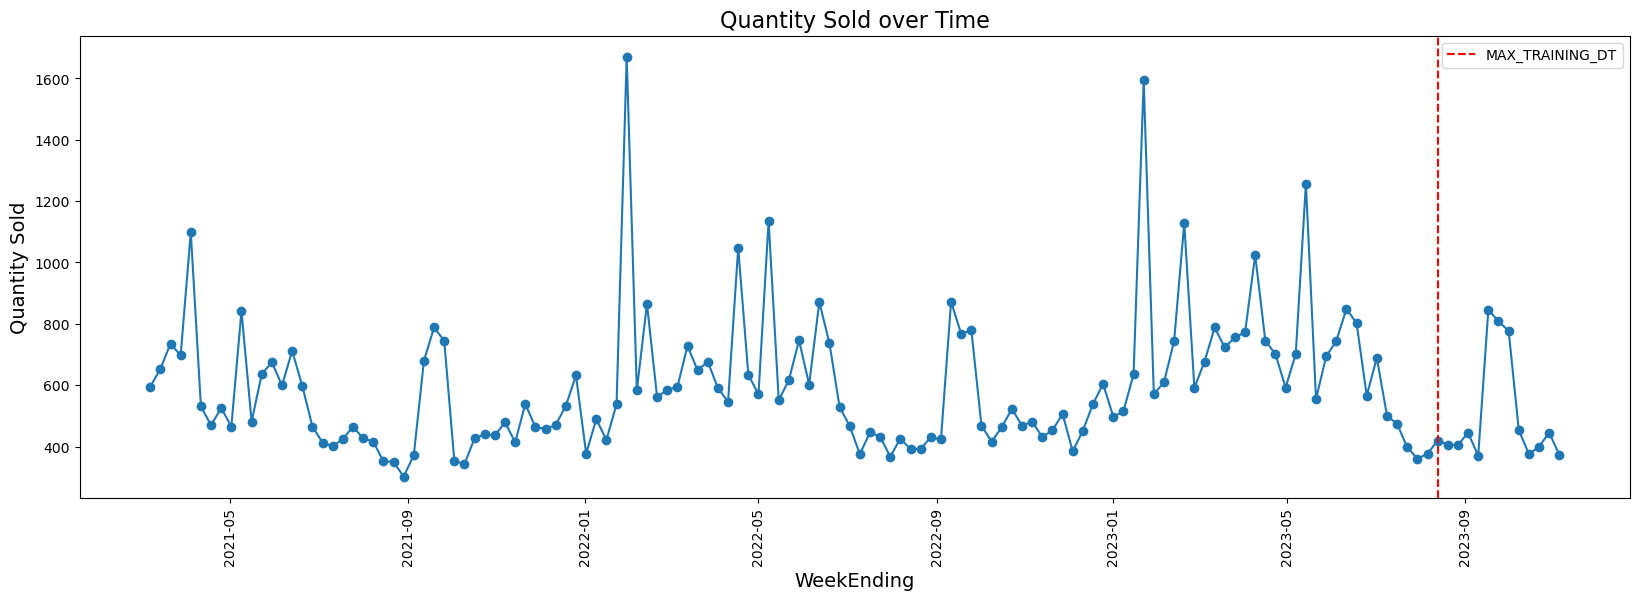

AutoCorrelations


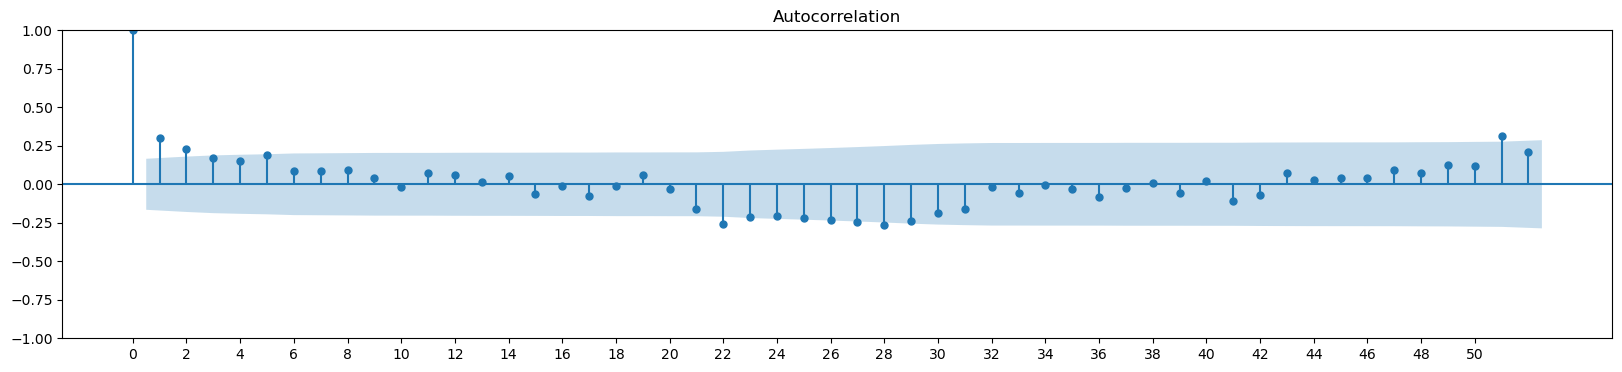

Understanding if the diff is stationaty


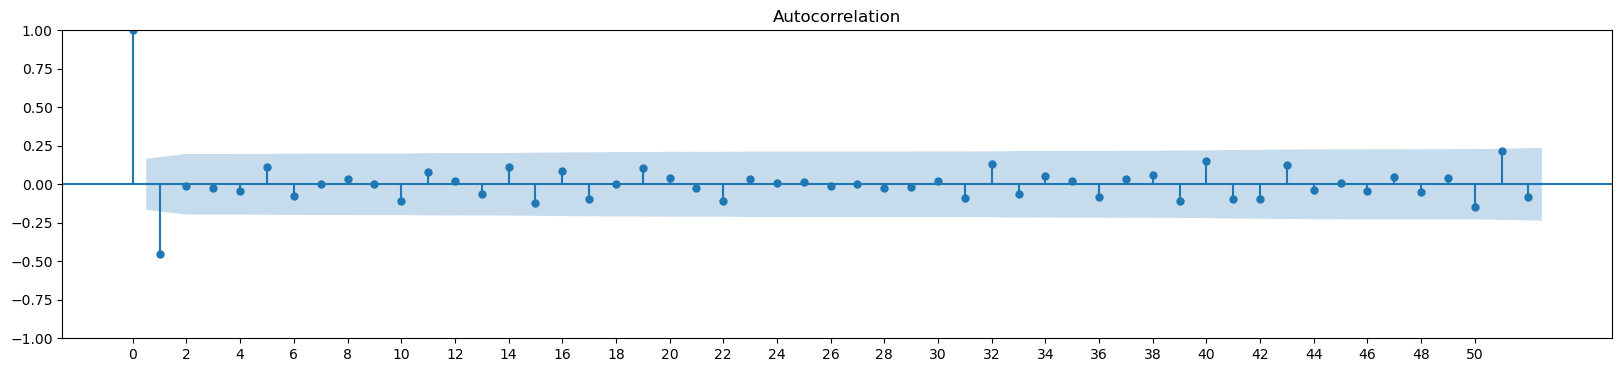

Selected Order (p, d, q): (1, 1, 4)
Selected Seasonal Order (P, D, Q, s): (1, 1, 0, 52)
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  127
Model:             SARIMAX(1, 1, 4)x(1, 1, [], 52)   Log Likelihood                -508.943
Date:                             Fri, 10 Nov 2023   AIC                           1049.885
Time:                                     15:11:21   BIC                           1086.750
Sample:                                          0   HQIC                          1064.591
                                             - 127                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8

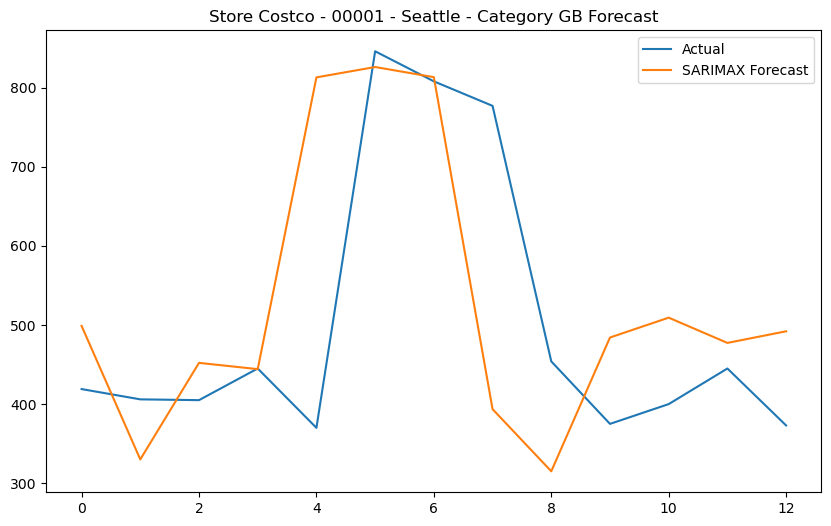

Store Costco - 00001 - Seattle - Category MB Forecast


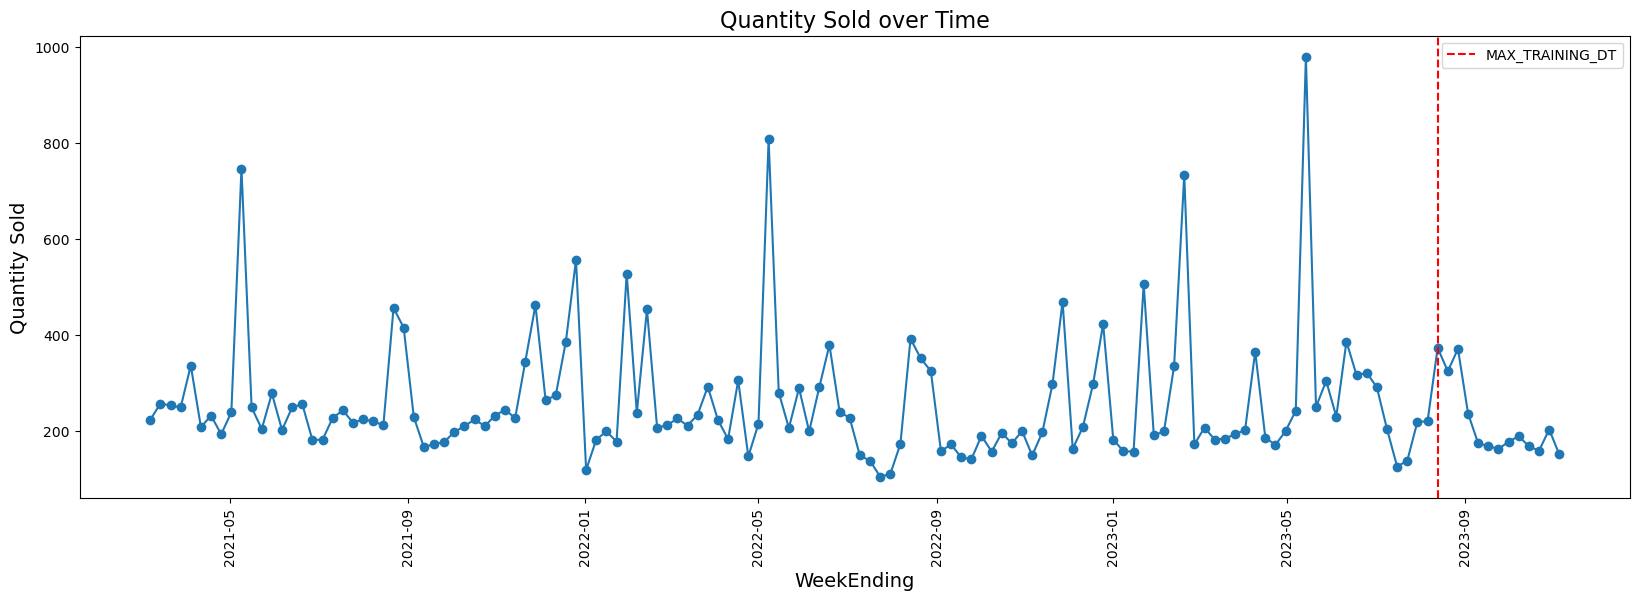

AutoCorrelations


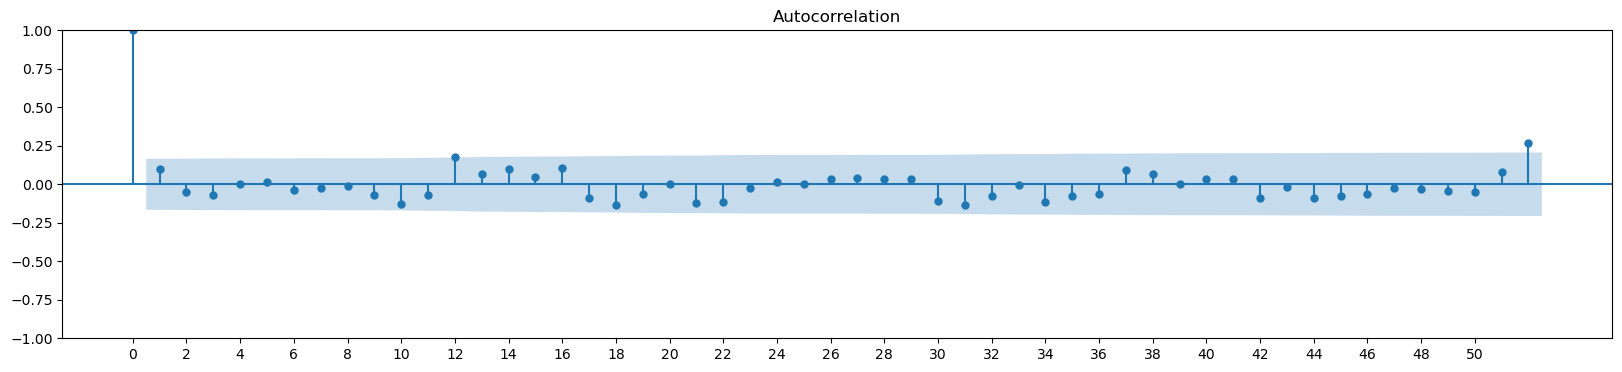

Understanding if the diff is stationaty


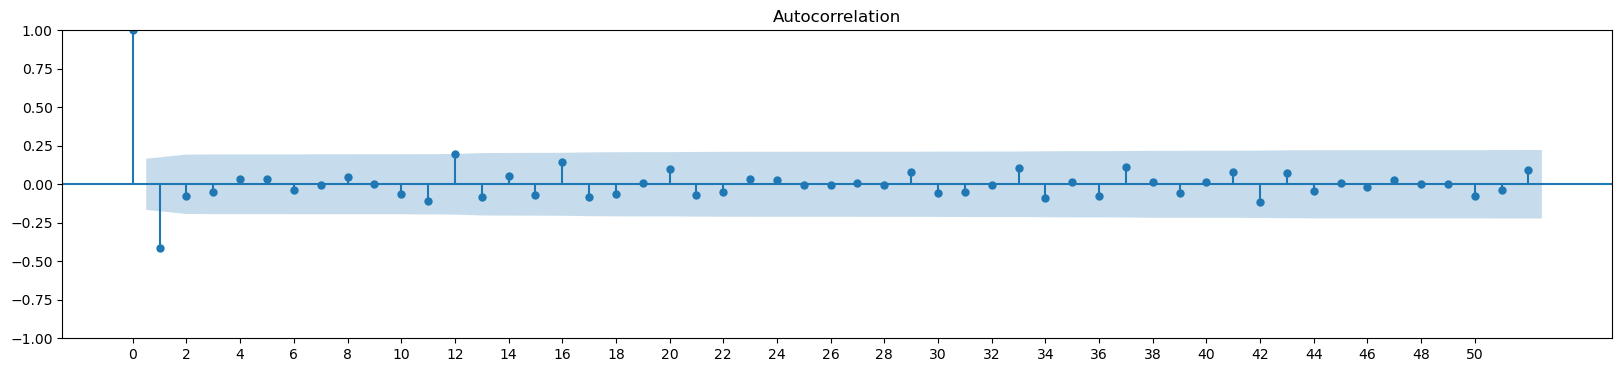

Selected Order (p, d, q): (1, 1, 4)
Selected Seasonal Order (P, D, Q, s): (1, 1, 0, 52)
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  127
Model:             SARIMAX(1, 1, 4)x(1, 1, [], 52)   Log Likelihood                -474.085
Date:                             Fri, 10 Nov 2023   AIC                            980.171
Time:                                     15:11:38   BIC                           1017.036
Sample:                                          0   HQIC                           994.876
                                             - 127                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2

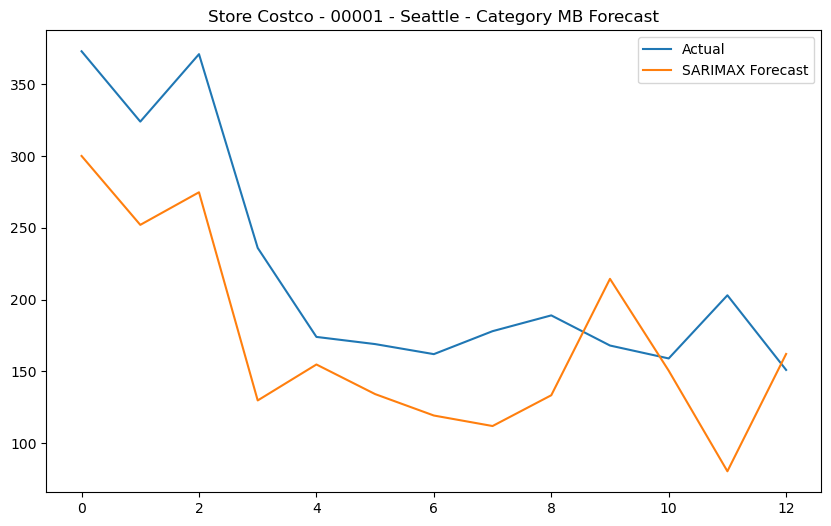

Store Costco - 00001 - Seattle - Category RB Forecast


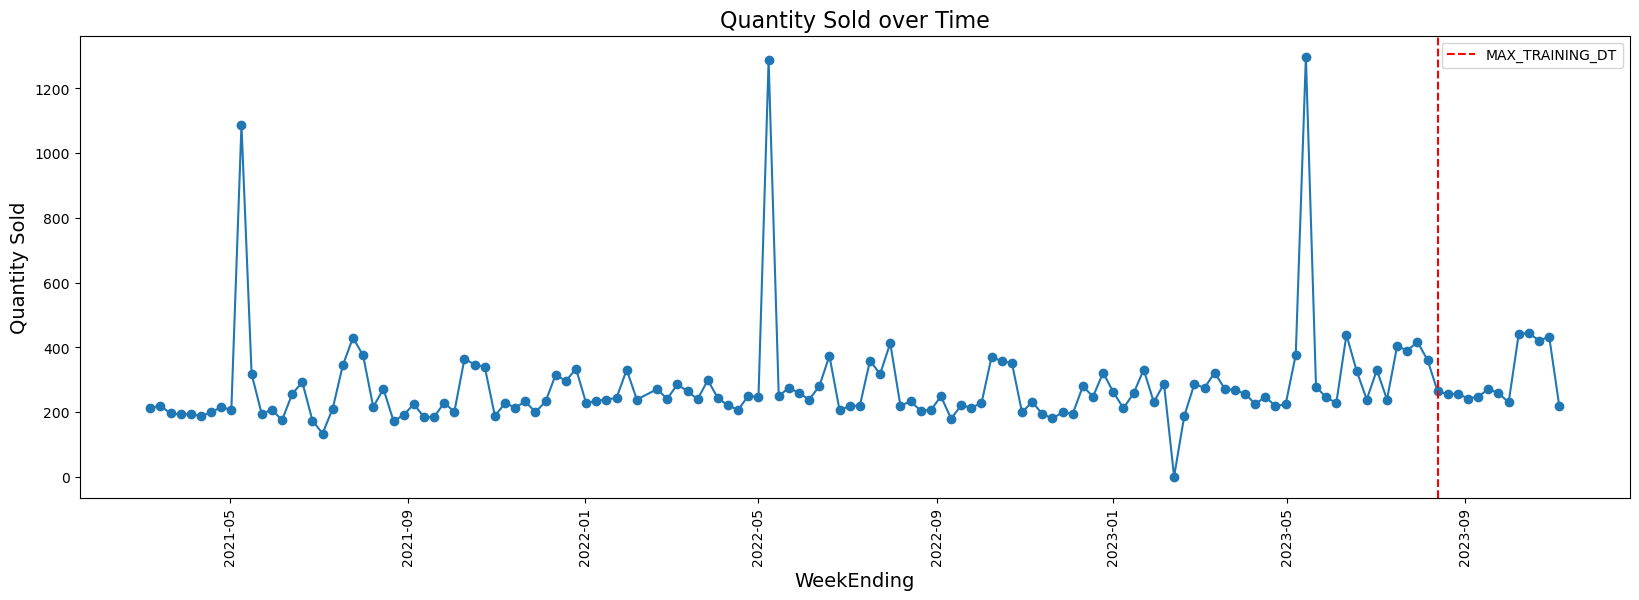

AutoCorrelations


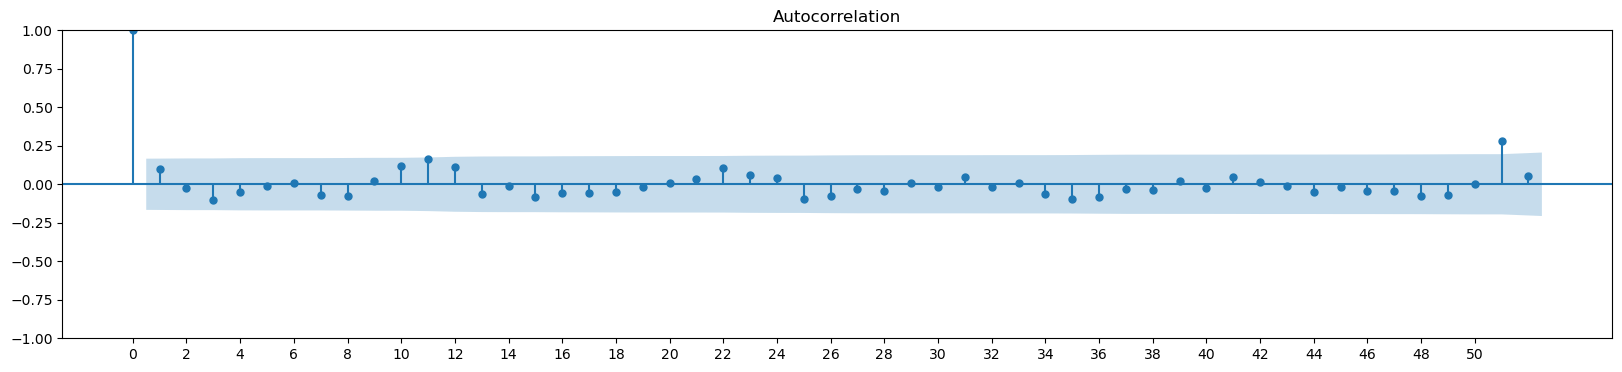

Understanding if the diff is stationaty


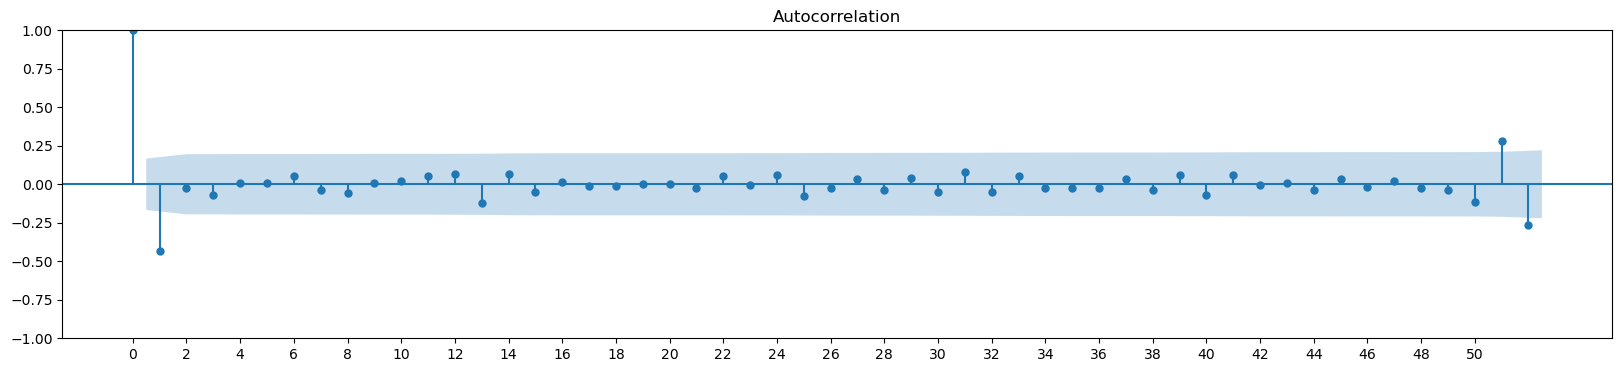

Selected Order (p, d, q): (1, 1, 4)
Selected Seasonal Order (P, D, Q, s): (1, 1, 0, 52)
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  126
Model:             SARIMAX(1, 1, 4)x(1, 1, [], 52)   Log Likelihood                -479.755
Date:                             Fri, 10 Nov 2023   AIC                            991.510
Time:                                     15:11:56   BIC                           1028.157
Sample:                                          0   HQIC                          1006.114
                                             - 126                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0

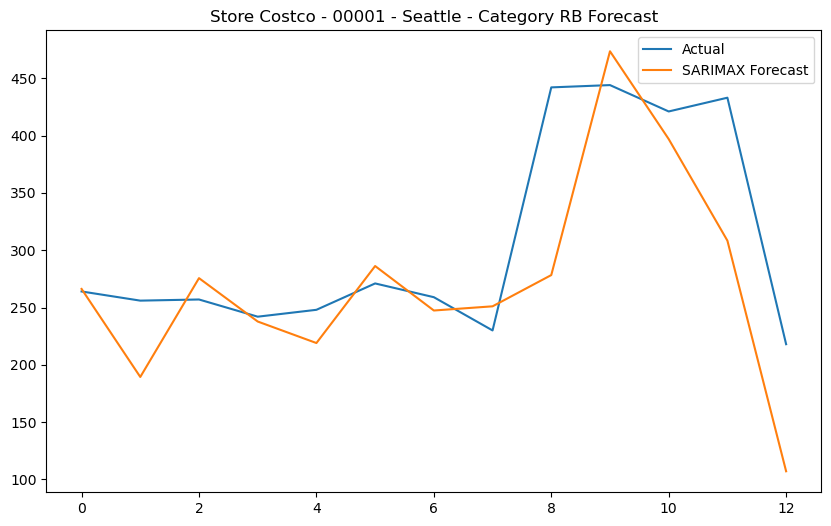

In [105]:
# Loop over df_mode per store/category and train models...
 
stores = df_model['Store'].unique()  # Extract unique store values
categories = df_model['CategoryItemCode'].unique()  # Extract unique category values

for store in stores:
    for category in categories:
        
        df_model_store = df_model[(df_model['Store'] == store) & (df_model['CategoryItemCode'] == category)]
        df_model_store=df_model_store.drop(['Facility','Store','CategoryItemCode'], axis=1)
        df_model_store = df_model_store.sort_values(by='WeekEnd')
        df_model_store.set_index('WeekEnd', inplace=True)
       
                
        # This will work to correct NAN when fillna is removed. 
        df_model_store['GasValue']=df_model_store['GasValue'].interpolate(method='linear')
        df_model_store['RoundedRetailPrice']= df_model_store['RoundedRetailPrice'].interpolate(method='linear')        
    
        df_model_store_train=df_model_store.loc[df_model_store.index < MAX_TRAINING_DT]
        df_model_store_test=df_model_store.loc[df_model_store.index >= MAX_TRAINING_DT]
        
                
        if len(df_model_store) < 30:
            # If fewer than 30 observations, skip this store-category combination
            print(f"Skipping Store {store} - Category {category}: Insufficient data for modeling" ,len(y))
            continue    
        
        print(f'Store {store} - Category {category} Forecast')
        
        
        # Plotting Sales over time
        plt.figure(figsize=(20, 6))
        plt.plot(df_model_store.index, df_model_store['QuantitySold'], marker='o', linestyle='-')
        plt.axvline(MAX_TRAINING_DT, color='red', linestyle='--', label='MAX_TRAINING_DT')
        plt.xlabel('WeekEnding', fontsize=14)
        plt.ylabel('Quantity Sold', fontsize=14)
        plt.title('Quantity Sold over Time', fontsize=16)
        plt.xticks(rotation='vertical')
        plt.legend()
        plt.show()
        
        
        
        print('AutoCorrelations')
       
        fig, ax= plt.subplots(figsize=(20,4))
        tsaplots.plot_acf(df_model_store['QuantitySold'], lags=52, ax=ax)
        plt.xticks(ticks=range(0,52,2))
        plt.show()
    
        
        print('Understanding if the diff is stationaty')
        
        fig, ax= plt.subplots(figsize=(20,4))
        tsaplots.plot_acf( df_model_store['QuantitySold'].diff().dropna(), lags=52, ax=ax)
        plt.xticks(ticks=range(0,52,2))
        plt.show()
        
            
        
        # Example structure using SARIMAX for demonstration
        X_train= df_model_store_train.drop(['QuantitySold'], axis=1)
        X_test = df_model_store_test.drop(['QuantitySold'], axis=1)
        y_train= df_model_store_train['QuantitySold']
        y_test = df_model_store_test['QuantitySold']
        
        y_train = np.asarray(y_train)
        X_train = np.asarray(X_train)
        
        y_test = np.asarray(y_test)
        X_test = np.asarray(X_test)
      
       
        # Define SARIMAX model
        order = (1, 1, 4)  # Example order of the ARIMA model - you can adjust this based on your data
        seasonal_order = (1, 1, 0, 52)  # Example seasonal order
        trend=(0,0)
        #order = auto_arima(y_train, exogenous=X_train, seasonal=True, suppress_warnings=True).order
        #seasonal_order = auto_arima(y_train, exogenous=X_train, seasonal=True, suppress_warnings=True).seasonal_order
        print("Selected Order (p, d, q):", order)
        print("Selected Seasonal Order (P, D, Q, s):", seasonal_order)

        
        sarimax_model = SARIMAX(endog=y_train, exog=X_train, order=order, trend=trend, seasonal_order=seasonal_order)
     
        # Fit SARIMAX model
        sarimax_fit = sarimax_model.fit()
        # Access the estimated coefficients of all parameters, including exogenous variables
        print(sarimax_fit.summary())
        
        # Forecast using SARIMAX
        store_category_forecast = sarimax_fit.get_forecast(steps=len(y_test), exog=X_test)
        predicted_values = store_category_forecast.predicted_mean
        
        mse = mean_squared_error(y_test, predicted_values)
        print(f'Mean Squared Error: {mse}')
        
        
        print('Forecast')
        # Visualize the forecasted values
        plt.figure(figsize=(10, 6))
        plt.plot(y_test, label='Actual')
        plt.plot(predicted_values, label='SARIMAX Forecast')
        plt.title(f'Store {store} - Category {category} Forecast')
        plt.legend()
        plt.show()
        
        
 


<p> Work on defining how to project gas forward? 2 week trend? use current price? </p>

In [ ]:
merged_df['GasValueTrend']=merged_df['GasValue']/merged_df['GasValue'].shift(1)

In [51]:
#Function to 'Step' randomly in hyperparameter space to build optimization for hyper parameters
x0={'p':1,'d':1,'q':0,'P':0,'D':0,'Q':0,'a0':1,'a1':0}

def step(params):
    updated_params=deepcopy(params)
    selected_variable=np.random.choice(['p','d','q','P','D','Q','a0','a1'], size=1)[0]
    current_value= updated_params[selected_variable]
    # Update the current value randomly
    updated_value = current_value + np.random.choice([-1,1],size=1)[0]
    # enforce parameters limits
    if(selected_variable in ['p','q']):
        low, high = 0,6
    else:
        
        low, high = 0,1
        
    updated_value = min([max([low,updated_value]),high])
    updated_params[selected_variable]= updated_value
    
    return   updated_params

step(x0)

{'p': 1, 'd': 1, 'q': 0, 'P': 0, 'D': 0, 'Q': 0, 'a0': 1, 'a1': 0}